## MSDS422 Assignment 5 - Principal Component Analysis

**Table of contents:**

*   System & Data Setup (MNIST)
*   Model 1: Random Forest Fit w/ out PCA
*   Model 2: Principal Component Analysis
*   Model 3: Random Forest w/ reduced data set
*   Analysis: Model Comparison and Timing
*   Model 4: re-run dimension reduction on training data & re-run model
*   Conclusion

## Setup

In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.model_selection import train_test_split

### MNIST Dataset

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


In [3]:
# Load MNIST dataset
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

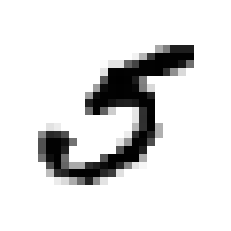

In [6]:
# Plot digits and check data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

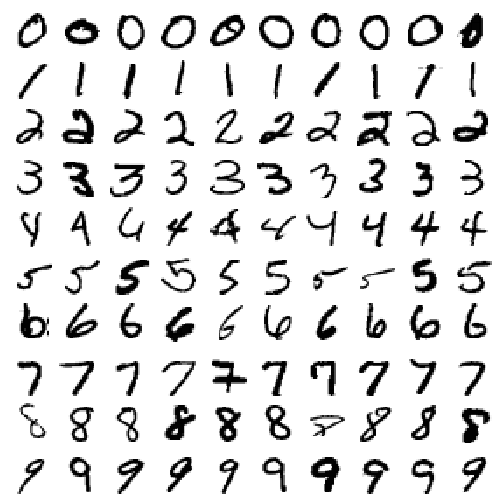

In [9]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [10]:
# Split dataset into training and testing data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
y_test.shape

(10000,)

In [12]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Model 1: Random Forest Classifier - all variables

In [14]:
%%time
start = time.process_time()

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_features = 'sqrt', n_estimators=784)
clf.fit(X_train, y_train)
duration1 = time.process_time() - start

CPU times: user 4min 35s, sys: 1.73 s, total: 4min 36s
Wall time: 4min 38s


In [15]:
%%time
start = time.process_time()
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(clf, X_train, y_train)
duration2 = time.process_time() - start

CPU times: user 17min 46s, sys: 7.71 s, total: 17min 54s
Wall time: 18min 1s


In [16]:
y_scores.shape

(60000,)

In [17]:
# Access classification performance on training data
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                                classification_report, confusion_matrix
print('f1 score = {0}'.format(f1_score(y_train, y_scores, average="macro")))
print('precision = {0}'.format(precision_score(y_train, y_scores, average="macro")))
print('recall = {0}'.format(recall_score(y_train, y_scores, average="macro")))

f1 score = 0.9692336992203447
precision = 0.9692406741857793
recall = 0.9692484472953045


In [18]:
%%time
start = time.process_time()
y_test_scores = cross_val_predict(clf, X_test, y_test)
duration3 = time.process_time() - start
y_test.shape

CPU times: user 1min 56s, sys: 1.23 s, total: 1min 57s
Wall time: 1min 58s


(10000,)

In [19]:
# Access classification performance on testing data
print('f1 score = {0}'.format(f1_score(y_test, y_test_scores, average="macro")))
print('precision = {0}'.format(precision_score(y_test, y_test_scores, average="macro")))
print('recall = {0}'.format(recall_score(y_test, y_test_scores, average="macro")))

f1 score = 0.9500733806091048
precision = 0.9504076205374281
recall = 0.949898236229387


[[ 966    1    0    0    0    4    6    1    2    0]
 [   0 1121    3    3    0    1    4    1    2    0]
 [   8    0  971    8   10    2    7   17    7    2]
 [   1    0   20  942    1   16    0   13   14    3]
 [   2    2    2    0  935    0    6    0    3   32]
 [   6    5    2   28    4  820   10    3    8    6]
 [   8    4    3    0    4    3  932    0    4    0]
 [   2   10   23    0    7    0    0  964    4   18]
 [   4    7    5   14    5    5    4    5  914   11]
 [   7    7    2   11   17    3    1    6   15  940]]


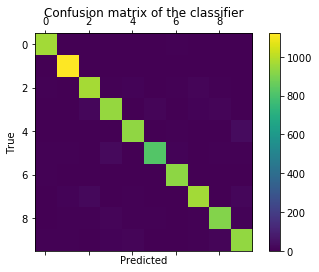

In [20]:
from sklearn.metrics import confusion_matrix
conf_mx1 = confusion_matrix(y_test, y_test_scores)
print(conf_mx1)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx1)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

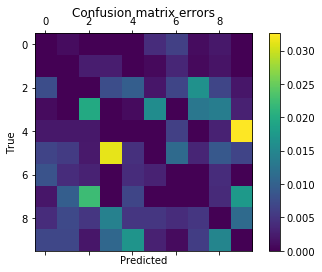

In [21]:
row_sums = conf_mx1.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx1 / row_sums
np.fill_diagonal(norm_conf_mx, 0)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx)
plt.title('Confusion matrix errors')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
Model1 = duration1+duration2+duration3

## Model 2: Principal Components Analysis (PCA)


In [24]:
%%time
from sklearn.decomposition import PCA
start = time.process_time()
pca = PCA()
pca.fit(mnist["data"])
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
duration4 = time.process_time() - start

CPU times: user 47.7 s, sys: 1.07 s, total: 48.7 s
Wall time: 8.31 s


In [25]:
#principle components from PCA
d

154

Text(164, 0.900797142697461, '154')

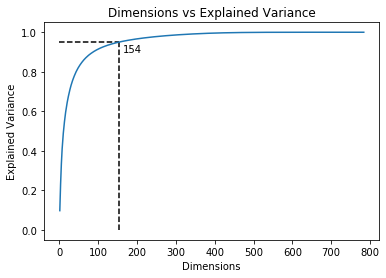

In [26]:
# Plot the PCA Cumulative Variance Sum Curve
x_len = len(pca.explained_variance_ratio_)
x = np.linspace(1, x_len, x_len, dtype=int)
plt.plot(x, cumsum)
plt.hlines(y=cumsum[d], xmin=0, xmax=d, linestyles="dashed")
plt.vlines(x=d, ymin=0, ymax=cumsum[d], linestyles="dashed")
plt.title("Dimensions vs Explained Variance")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.annotate(s="{}".format(d), xy=(d+10, cumsum[d]-0.05))

### Model 3: Random Forest - reduced data set

In [27]:
%%time
start = time.process_time()
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)
duration5 = time.process_time() - start

CPU times: user 23.7 s, sys: 2.64 s, total: 26.3 s
Wall time: 4.68 s


In [28]:
X_reduced.shape

(60000, 154)

In [29]:
%%time
start = time.process_time()
clf_2 = RandomForestClassifier(max_features = 'sqrt',n_estimators=154)
clf_2.fit(X_reduced, y_train)
duration6 = time.process_time() - start

CPU times: user 1min 57s, sys: 522 ms, total: 1min 58s
Wall time: 1min 58s


In [30]:
%%time
start = time.process_time()
y_scores_2 = cross_val_predict(clf_2, X_reduced, y_train)
duration7 = time.process_time() - start

CPU times: user 7min 27s, sys: 2.18 s, total: 7min 30s
Wall time: 7min 32s


In [31]:
Model2= duration4 + duration5 + duration6 + duration7

In [32]:

y_scores_2.shape

(60000,)

In [33]:
# Access classification performance on training data
print('f1 score = {0}'.format(f1_score(y_train, y_scores_2, average="macro")))
print('precision = {0}'.format(precision_score(y_train, y_scores_2, average="macro")))
print('recall = {0}'.format(recall_score(y_train, y_scores_2, average="macro")))

f1 score = 0.9458812266245952
precision = 0.9459551426435562
recall = 0.9458803798796268


In [34]:
y_test_scores_2 = cross_val_predict(clf_2, X_test_reduced, y_test)
y_test.shape

(10000,)

In [35]:
# Access classification performance on testing data
print('f1 score = {0}'.format(f1_score(y_test, y_test_scores_2, average="macro")))
print('precision score = {0}'.format(precision_score(y_test, y_test_scores_2, average="macro")))
print('recall = {0}'.format(recall_score(y_test, y_test_scores_2, average="macro")))

f1 score = 0.9152015419045412
precision score = 0.9156888797123315
recall = 0.91518907979166


In [36]:
conf_mx2 = confusion_matrix(y_test, y_test_scores_2)
conf_mx2

array([[ 954,    0,    5,    2,    0,    6,    8,    1,    4,    0],
       [   0, 1109,    7,    5,    0,    1,    3,    0,    9,    1],
       [  13,    1,  938,   13,   17,    3,    6,   13,   25,    3],
       [   4,    2,   18,  917,    3,   23,    2,    7,   27,    7],
       [   1,    5,    8,    1,  898,    3,   15,    9,    4,   38],
       [  14,    2,    4,   56,   14,  758,   13,    2,   21,    8],
       [  12,    5,    1,    2,    7,    9,  920,    0,    2,    0],
       [   5,   19,   21,    3,   11,    1,    2,  945,    2,   19],
       [   9,    1,   20,   31,   12,   27,    4,   14,  844,   12],
       [   8,    6,   10,   15,   45,    6,    2,   30,    5,  882]])

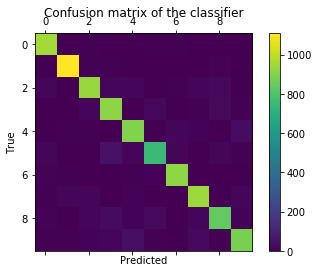

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx2)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

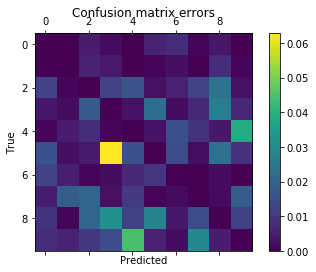

In [38]:
row_sums = conf_mx2.sum(axis=1, keepdims=True)
norm_conf_mx2 = conf_mx2 / row_sums
np.fill_diagonal(norm_conf_mx2, 0)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx2)
plt.title('Confusion matrix errors')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### The PCA Model has a design flaw because the experiment is applying principal component analysis (PCA) to the entire set of data. The dataset should be split into train and test sets prior to running PCA. To correct the flaw, the train set will be split into a train and validation set. The PCA will be run on these sets prior to making predictions on the test set

### Model 4: re-run dimension reduction on training data & re-run model

In [40]:
pca_2 = PCA()
pca_2.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d2 = np.argmax(cumsum >= 0.95) + 1

In [41]:
d2

149

Text(159, 0.9004918065491405, '149')

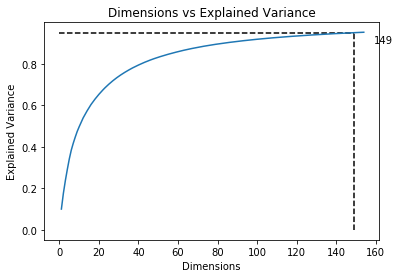

In [42]:
# Plot the PCA Cumulative Variance Sum Curve
x_len = len(pca.explained_variance_ratio_)
x = np.linspace(1, x_len, x_len, dtype=int)
plt.plot(x, cumsum)
plt.hlines(y=cumsum[d2], xmin=0, xmax=d2, linestyles="dashed")
plt.vlines(x=d2, ymin=0, ymax=cumsum[d2], linestyles="dashed")
plt.title("Dimensions vs Explained Variance")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.annotate(s="{}".format(d2), xy=(d2+10, cumsum[d2]-0.05))

In [43]:
%%time
start = time.process_time()
pca_3 = PCA(n_components = 149)
X_train_reduced_3 = pca_3.fit_transform(X_train)
X_test_reduced_3 = pca_3.fit_transform(X_test)
duration8 = time.process_time() - start

CPU times: user 23.8 s, sys: 2.63 s, total: 26.5 s
Wall time: 4.61 s


In [44]:
%%time
start = time.process_time()
clf_3 = RandomForestClassifier(max_features = 'sqrt', n_estimators=149)
clf_3.fit(X_train_reduced_3, y_train)
duration9 = time.process_time() - start

CPU times: user 1min 53s, sys: 467 ms, total: 1min 53s
Wall time: 1min 54s


In [45]:
%%time
from sklearn.model_selection import cross_val_predict
start = time.process_time()
y_train_scores_3 = cross_val_predict(clf_3, X_train_reduced_3, y_train)
y_test_scores_3 = cross_val_predict(clf_3, X_test_reduced_3, y_test)
duration10 = time.process_time() - start

CPU times: user 8min 8s, sys: 2.8 s, total: 8min 11s
Wall time: 8min 14s


In [46]:
print(f1_score(y_train, y_train_scores_3, average="macro"))
print(precision_score(y_train, y_train_scores_3, average="macro"))
print(recall_score(y_train, y_train_scores_3, average="macro"))

0.9467419090088496
0.9467963694867908
0.9467550206738933


In [47]:
print(f1_score(y_test, y_test_scores_3, average="macro"))
print(precision_score(y_test, y_test_scores_3, average="macro"))
print(recall_score(y_test, y_test_scores_3, average="macro"))

0.9162446237663235
0.9167428763388591
0.9161753896804792


In [48]:
conf_mx3 = confusion_matrix(y_test, y_test_scores_3)
conf_mx3

array([[ 952,    0,    4,    3,    0,    3,   11,    1,    6,    0],
       [   0, 1111,    4,    4,    0,    1,    3,    2,   10,    0],
       [  18,    1,  937,   14,   16,    3,    7,   13,   23,    0],
       [   2,    2,   23,  918,    2,   19,    3,    9,   27,    5],
       [   1,    8,    6,    1,  904,    3,   18,    3,    4,   34],
       [   8,    2,    8,   58,   10,  768,   14,    4,   13,    7],
       [  13,    5,    6,    1,    5,    9,  913,    0,    6,    0],
       [   2,   16,   20,    4,    8,    3,    0,  945,    3,   27],
       [   9,    1,   20,   31,   13,   26,    2,    9,  847,   16],
       [   8,    6,    9,   16,   43,    6,    2,   32,    8,  879]])

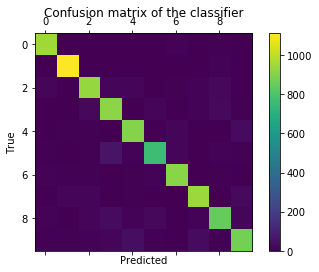

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx3)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

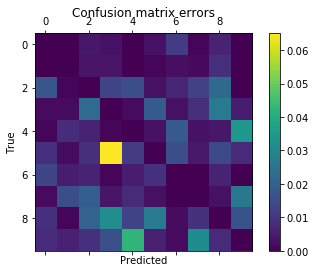

In [50]:
row_sums = conf_mx3.sum(axis=1, keepdims=True)
norm_conf_mx3 = conf_mx3 / row_sums
np.fill_diagonal(norm_conf_mx3, 0)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx3)
plt.title('Confusion matrix errors')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [51]:
Model3=duration8+duration9+duration10

In [52]:
def convert(seconds): 
    seconds = seconds % (24 * 3600) 
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%02d:%02d" % (minutes, seconds)


In [53]:
# Driver program 
m1 = Model1
m2 = Model2
m3 = Model3
print(convert(m1)) 
print(convert(m2)) 
print(convert(m3)) 

24:28
10:43
10:31


### Analysis - Model comparison & timing

In [55]:
print('Model 1 Original 784-Varibiable Model, Test: = {0}'.format(f1_score(y_test, y_test_scores, average="macro"))),
print('Model 1 Time:')
print(convert(m1)) 
print('Model 3 95% PCA Model, Test: {0}'.format(f1_score(y_test, y_test_scores_2, average="macro")))
print('Model 3 Time:')
print(convert(m2)) 
print('Model 4 Random Forest with reduced variables and PCA, Test: {0}'.format(f1_score(y_test, y_test_scores_3, average="macro")))
print('Model 4 Time:')
print(convert(m3))


Model 1 Original 784-Varibiable Model, Test: = 0.9500733806091048
Model 1 Time:
24:28
Model 3 95% PCA Model, Test: 0.9152015419045412
Model 3 Time:
10:43
Model 4 Random Forest with reduced variables and PCA, Test: 0.9162446237663235
Model 4 Time:
10:31


# Conclusion

**Recommendation to reduce data dimensions using PCA on the training data set (model 3).**  Resulting Random Forest model uses 149 estimators.  The F1 and Precision scores of the recommended model are .94 accuracy on the training data, and .92 accuracy on the test data.  The time it takes to run the model is ~10 minutes, which is a 60% reduction in timing for a slightly improved test result (model 1).